In [1]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import diffprivlib.models as dpm
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") #warnings.filterwarnings("default")

# Load data

In [2]:
trump_data = pd.read_csv('../data/2016-cces-trump.csv')

# Visualize data


In [3]:
trump_data

,uid,stateabb,inputstate,race,angryracism,whiteadv,fearraces,racerare,acograc,aemprac,...,se_lrelig,z_acograc,z_aemprac,z_lcograc,z_lemprac,z_pid7na,z_lrelig,z_ideo,z_famincr,z_age
0,1,NH,33,1,2.0,3.0,1.0,3.0,3.0,1.5,...,0.246291,0.230760,-0.271252,0.295012,-0.146684,0.338328,-0.102495,-0.001742,NaN,-0.026144
1,2,LA,22,1,1.0,4.0,1.0,1.0,2.5,1.0,...,NaN,0.010444,-0.592603,-0.115771,-0.654787,0.103767,NaN,-0.001742,-0.044765,-0.768742
2,3,MO,29,2,NaN,NaN,NaN,NaN,NaN,NaN,...,0.278047,NaN,NaN,NaN,NaN,-0.599915,0.306842,0.920136,-0.354468,0.122376
3,4,AL,1,2,NaN,NaN,NaN,NaN,NaN,NaN,...,0.234668,NaN,NaN,NaN,NaN,0.103767,0.037493,0.459197,-0.819021,-0.590518
4,5,CO,8,1,2.0,1.0,1.0,1.0,1.0,1.5,...,0.321913,-0.650504,-0.271252,-0.746858,-0.146684,-0.365354,-0.604388,-0.462680,0.110086,-0.412295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64595,64596,NY,36,2,NaN,NaN,NaN,NaN,NaN,NaN,...,0.575410,NaN,NaN,NaN,NaN,-0.365354,0.908217,0.459197,-0.199617,-0.649926
64596,64597,CO,8,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0.237046,NaN,NaN,NaN,NaN,0.103767,-0.053592,NaN,-0.354468,-0.531110
64597,64598,LA,22,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0.245402,NaN,NaN,NaN,NaN,-0.130794,-0.090021,0.920136,-0.819021,-0.293479
64598,64599,RI,44,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0.509297,NaN,NaN,NaN,NaN,-0.365354,-0.847906,-0.462680,-0.199617,-0.560814


### TODO: Figure out what to do about the NaNs. For now, replacing with N(0,1) noise

# Cleaning data

In [4]:
trump_data = trump_data.dropna(subset=['votetrump'])
trump_data.fillna(0, inplace = True)

In [5]:
for col in trump_data.columns:
    values = [v for v in trump_data[col].values if v!=np.nan]

    if isinstance(values[0], str):
        print(str(values[0]))
        map = {v:i for i, v in enumerate(values)}
        trump_data[col].replace(map, inplace=True)

NH
New Hampshire
Northeast
New England
3: Gen X


In [6]:
vote_cols = [ 'vote' not in col and 'uid' not in col for col in  trump_data.columns ]
# vote_cols = [ col for col in  trump_data.columns if  'vote' not in col and 'uid' not in col ]

In [7]:
y = trump_data['votetrump'].to_numpy()
X = trump_data.loc[:,vote_cols].to_numpy()
X = (X- np.min(X, axis = 0, keepdims = True))/(np.max(X, axis = 0, keepdims = True) - np.min(X, axis = 0, keepdims = True))
# X = X[:, :5]
X = preprocessing.normalize(X, norm='l2')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Baseline Model

In [9]:
pca = PCA(n_components=5)
tX_train = pca.fit_transform(X_train)
tX_test = pca.transform(X_test)

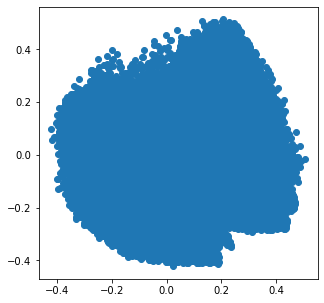

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.scatter(tX_train[:, 0], tX_train[:, 1])

In [11]:
clf = LogisticRegression(random_state = 0, max_iter = 200).fit(tX_train, y_train)

In [12]:
print(f"Performance on training data {clf.score(tX_train, y_train)}")
print(f"Performance on test data {clf.score(tX_test, y_test)}")

opt_accuracy = clf.score(tX_test, y_test)

Performance on training data 0.8771773643134811
Performance on test data 0.8784830410397935


# PCA => DP Logistic Regression

0
1
2
3
4


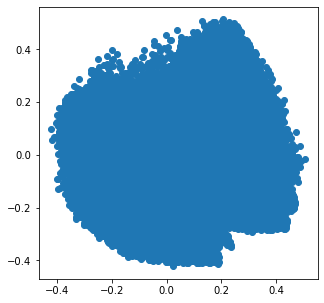

In [30]:
pca = PCA(n_components=5)
tX_train = pca.fit_transform(X_train)
tX_test = pca.transform(X_test)
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.scatter(tX_train[:, 0], tX_train[:, 1])
epsilons = np.logspace(-3, 0, 50)
curves = []
for i in range(5):
    print(i)
    accuracy = []
    for epsilon in epsilons:
        dp_clf = dpm.LogisticRegression(epsilon=epsilon, max_iter = 200).fit(tX_train, y_train, )
        accuracy.append(dp_clf.score(tX_test, y_test))

    curves += [accuracy]


In [31]:
mean_score1 = np.mean(np.array(curves), axis = 0)

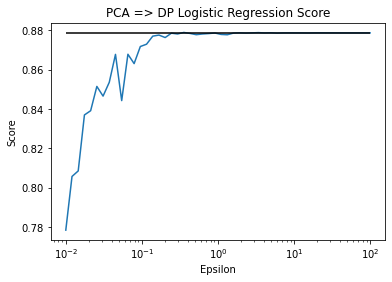

In [15]:
ax = plt.subplot(111)
ax.plot(epsilons, mean_score1)
ax.set_title("PCA => DP Logistic Regression Score")
ax.set_xlabel("Epsilon")
ax.set_ylabel("Score")
ax.set_xscale('log')
ax.hlines(opt_accuracy, epsilons[0],epsilons[-1] , color = "black")

# DP PCA => Logistic Regression

In [23]:
new_epsilons = np.logspace(-3, -1, 50)
curves = []
for i in range(10):
    accuracy = []
    print(i)
    for epsilon in new_epsilons:
        # print("epsilon",epsilon)
        dp_pca = dpm.PCA(n_components=5, epsilon = epsilon)
        tX_train = dp_pca.fit_transform(X_train)
        tX_test = dp_pca.transform(X_test)
        dp_clf = LogisticRegression(max_iter = 200).fit(tX_train, y_train, )
        accuracy.append(dp_clf.score(tX_test, y_test))

    curves += [accuracy]


0
epsilon 0.001
epsilon 0.0010985411419875584
epsilon 0.0012067926406393288
epsilon 0.0013257113655901094
epsilon 0.0014563484775012444
epsilon 0.0015998587196060573
epsilon 0.0017575106248547913
epsilon 0.0019306977288832496
epsilon 0.0021209508879201904
epsilon 0.002329951810515372
epsilon 0.002559547922699536
epsilon 0.002811768697974231
epsilon 0.0030888435964774815
epsilon 0.00339322177189533
epsilon 0.003727593720314938
epsilon 0.004094915062380423
epsilon 0.004498432668969444
epsilon 0.004941713361323833
epsilon 0.005428675439323859
epsilon 0.005963623316594642
epsilon 0.006551285568595509
epsilon 0.0071968567300115215
epsilon 0.0079060432109077
epsilon 0.00868511373751352
epsilon 0.009540954763499945
epsilon 0.010481131341546858
epsilon 0.01151395399326447
epsilon 0.012648552168552958
epsilon 0.013894954943731374
epsilon 0.015264179671752334
epsilon 0.016768329368110076
epsilon 0.018420699693267154
epsilon 0.020235896477251564
epsilon 0.022229964825261943
epsilon 0.024420530945

In [24]:
mean_score2 = np.mean(np.array(curves), axis = 0)

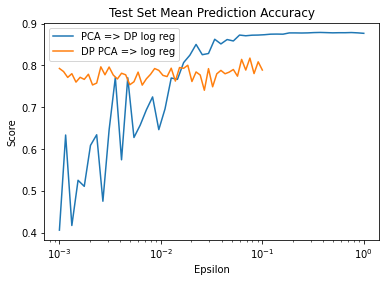

In [32]:
ax = plt.subplot(111)
ax.plot(epsilons, mean_score1, label = "PCA => DP log reg")
ax.plot(new_epsilons, mean_score2, label = "DP PCA => log reg")
ax.set_title("Test Set Mean Prediction Accuracy")
ax.legend()
ax.set_xlabel("Epsilon")
ax.set_ylabel("Score")
ax.set_xscale('log')
# ax.hlines(opt_accuracy, epsilons[0],epsilons[-1] , color = "black")

In [ ]:
curves

[[0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7968485711742188,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7970266180005341,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7970266180005341,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7971156414136918,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.7969375945873765,
  0.796937

# MOD-SULQ

In [ ]:
epsilons = np.logspace(-2, 0, 50)
deltas = np.logspace(-2, 0, 50)
d = X.shape[1]
n = X.shape[0]
for epsilon in epsilons:
    for delta in deltas:
        beta = (d+1)/(n * epsilon) * np.sqrt(2 * np.log((d**2 + d)/(delta * 2 * np.sqrt(2 * np.pi)))) + 1 / (n * np.sqrt(epsilon))
        print(beta)

0.0479761880586018
0.047623947873525356
0.04726907051801025
0.04691149585758854
0.04655116143706997
0.04618800235318567
0.04582195111810238
0.04545293751299459
0.045080888430774645
0.04470572770698343
0.04432737593773344
0.04394575028347181
0.04356076425718954
0.043172327495543034
0.04278034551117211
0.04238471942429122
0.04198534567139367
0.041582115688637344
0.04117491556716943
0.0407636256772889
0.04034812025793286
0.03992826696749406
0.039503926391422535
0.039074951501417904
0.03864118706026564
0.0382024689654864
0.037758623523930404
0.03730946664822327
0.03685480296452068
0.0363944248193052
0.03592811117090226
0.03545562634892652
0.03497671866190178
0.03449111882970661
0.033998538213131986
0.03349866680750172
0.032991170960749175
0.03247569076823747
0.03195183708652833
0.031419188095679895
0.030877285323737437
0.03032562902686225
0.02976367279265728
0.029190817200821503
0.028606402331708924
0.028009698856055934
0.02739989736293141
0.02677609548046893
0.026137282204386124
0.0254823

In [ ]:
A = 1/n * X.T @ X

In [ ]:
A.shape

(5, 5)

In [ ]:
A

array([[2.01463080e+09, 1.25910082e+06, 6.88279202e+04, 7.52206632e+04,
        1.18855427e+05],
       [1.25910082e+06, 1.03370896e+03, 4.17933099e+01, 4.71452417e+01,
        7.48120716e+01],
       [6.88279202e+04, 4.17933099e+01, 3.89036767e+00, 2.53865842e+00,
        3.88059735e+00],
       [7.52206632e+04, 4.71452417e+01, 2.53865842e+00, 3.73448767e+00,
        5.08370426e+00],
       [1.18855427e+05, 7.48120716e+01, 3.88059735e+00, 5.08370426e+00,
        9.16438173e+00]])

array([[0.55430328, 0.58181818, 0.        , 0.4       , 0.6       ],
       [0.96670082, 0.38181818, 0.        , 0.2       , 0.8       ],
       [0.98616803, 0.12727273, 0.        , 0.4       , 0.2       ],
       ...,
       [0.99897541, 0.43636364, 0.        , 0.2       , 0.2       ],
       [0.9994877 , 0.34545455, 0.        , 0.4       , 0.8       ],
       [1.        , 0.94545455, 0.        , 0.2       , 0.4       ]])

In [ ]:
np.max(X, axis = 0, keepdims = True)

array([[4.4931e+04, 5.6000e+01, 8.0000e+00, 5.0000e+00, 5.0000e+00]])

In [ ]:
np.min(X, axis = 0, keepdims = True)

array([[4.2979e+04, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00]])

In [ ]:
X

array([[4.4061e+04, 3.3000e+01, 1.0000e+00, 2.0000e+00, 3.0000e+00],
       [4.4866e+04, 2.2000e+01, 1.0000e+00, 1.0000e+00, 4.0000e+00],
       [4.4904e+04, 8.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00],
       ...,
       [4.4929e+04, 2.5000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00],
       [4.4930e+04, 2.0000e+01, 1.0000e+00, 2.0000e+00, 4.0000e+00],
       [4.4931e+04, 5.3000e+01, 1.0000e+00, 1.0000e+00, 2.0000e+00]])